17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R² Score: 0.998
RMSE: 0.203
MAE: 0.152


c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


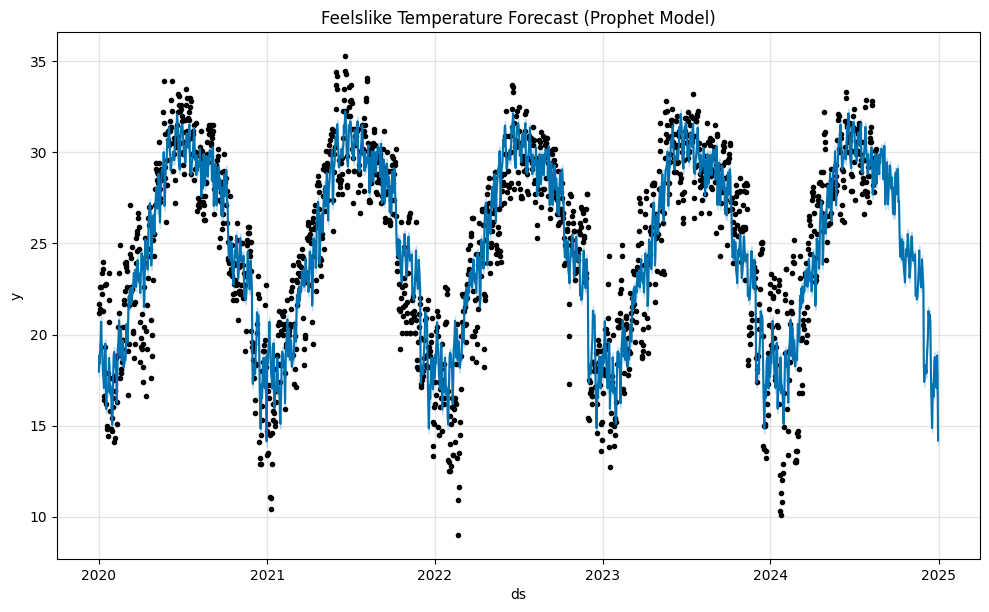

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load the dataset
file_path = '../../../dataset/data.csv'  # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Convert datetime to the correct format and rename for Prophet
data['ds'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')

# Prepare the target variable (feelslike) and features for Prophet
data['y'] = data['temp']

# Select the relevant features
features = ['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity']

# Step 1: Initialize the Prophet model
temp_model = Prophet(yearly_seasonality=True)

# Step 2: Add extra regressors (the selected features)
for feature in features:
    temp_model.add_regressor(feature)

# Step 3: Fit the model
temp_model.fit(data[['ds', 'y'] + features])

# Step 4: Predict on historical data
historical_forecast = temp_model.predict(data[['ds'] + features])

# Step 5: Calculate performance metrics (R², MAE, RMSE)
y_true = data['y'].values  # Actual feelslike temperatures
y_pred = historical_forecast['yhat'].values  # Predicted feelslike temperatures

# Calculate R² score
r2 = r2_score(y_true, y_pred)

# Calculate RMSE
rmse = mean_squared_error(y_true, y_pred, squared=False)

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)

# Display the performance metrics
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Step 6: Generate future dates (from 21/08/2024 to 31/12/2024)
future_dates = temp_model.make_future_dataframe(periods=len(pd.date_range('2024-08-21', '2024-12-31')), freq='D')

# Extract the day of the year from the future dates
future_dates['day_of_year'] = future_dates['ds'].dt.dayofyear

# Step 7: Fill future dates with historical averages for the regressors
historical_averages = data.groupby(data['ds'].dt.dayofyear)[features].mean()

# Handle future days mapping directly to historical averages (non-leap years)
future_features = pd.DataFrame({
    col: [historical_averages.loc[dayofyear if dayofyear in historical_averages.index else dayofyear - 1, col]
          for dayofyear in future_dates['day_of_year']]
    for col in features
})

# Combine future dates with future features
future_df = pd.concat([future_dates, future_features], axis=1)

# Step 8: Predict future feelslike temperatures
temp_forecast = temp_model.predict(future_df)

# Step 9: Display and save the predicted feelslike temperatures
temp_forecast[['ds', 'yhat']].tail()
temp_forecast[['ds', 'yhat']].to_csv('nofinetuning.csv', index=False)

# Step 10: Plot the forecasted feelslike temperatures
temp_model.plot(temp_forecast)
plt.title('Feelslike Temperature Forecast (Prophet Model)')
plt.show()
